**Introduction**

This model classify 7 skin lesions using deep learning and transfer learning.

Entire Web Application code using Flask at

Skin Lesions labels are:

nv

Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.
[700 images]

mel

Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.
[500 images]

bkl

"Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.
[500 images]

bcc

Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.
[300 images]

akiec

Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.
[200 images]

vasc

Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.
[142 images]


df

Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].
[115 images]


[Total images = 2015]


In [52]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(seed)
tensorflow.random.set_seed(101)

import tensorflow
import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.layers import GlobalAveragePooling2D


import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


# Create a new directory
base_dir = '/content/drive/MyDrive/base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
 
# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



In [4]:
df_data = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern
2,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern
3,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,vidir_modern
4,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern


In [5]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000003,1,1,1,1,1,1,1
1,HAM_0000015,1,1,1,1,1,1,1
2,HAM_0000016,1,1,1,1,1,1,1
3,HAM_0000020,1,1,1,1,1,1,1
4,HAM_0000038,1,1,1,1,1,1,1


In [6]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,no_duplicates
1,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern,no_duplicates
2,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern,has_duplicates
3,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,vidir_modern,has_duplicates
4,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,has_duplicates


In [7]:
df_data['duplicates'].value_counts()

no_duplicates     728
has_duplicates    266
Name: duplicates, dtype: int64

In [8]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(728, 9)

In [9]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(124, 9)

In [10]:
df_val['dx'].value_counts()

nv       106
akiec      5
bkl        4
mel        4
bcc        3
vasc       1
df         1
Name: dx, dtype: int64

In [11]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

870
124


In [12]:
df_train['dx'].value_counts()

nv       515
mel      122
bkl      119
bcc       60
akiec     32
df        11
vasc      11
Name: dx, dtype: int64

In [13]:
df_val['dx'].value_counts()

nv       106
akiec      5
bkl        4
mel        4
bcc        3
vasc       1
df         1
Name: dx, dtype: int64

In [14]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [15]:
# Get a list of images in each of the two folders
f1 = os.listdir('/content/drive/MyDrive/dataset')


# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in f1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/dataset', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)



# Transfer the val images
for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in f1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/dataset', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

        

In [16]:
# check how many train images we have in each folder

print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/df')))

515
122
119
60
32
11
11


In [17]:
# check how many val images we have in each folder

print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/df')))

106
4
4
3
5
1
1


In [18]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = '/content/drive/MyDrive/aug_dir1'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('/content/drive/MyDrive/base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('/content/drive/MyDrive/base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = '/content/drive/MyDrive/base_dir/train_dir/' + img_class


    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('/content/drive/MyDrive/aug_dir1')

Found 122 images belonging to 1 classes.
Found 119 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Found 32 images belonging to 1 classes.
Found 11 images belonging to 1 classes.
Found 11 images belonging to 1 classes.


In [19]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/train_dir/df')))

515
4930
4810
3650
3872
1331
1331


In [21]:
# Check how many val images we have in each folder.

print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/base_dir/val_dir/df')))

106
4
4
3
5
1
1


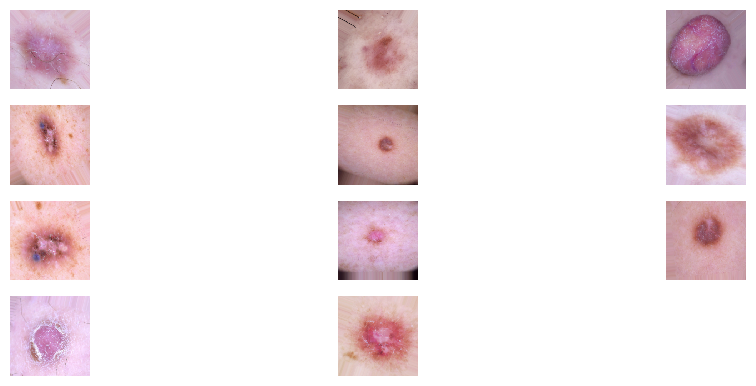

In [22]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [23]:
train_path = '/content/drive/MyDrive/base_dir/train_dir'
valid_path = '/content/drive/MyDrive/base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [24]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 20439 images belonging to 7 classes.
Found 124 images belonging to 7 classes.
Found 124 images belonging to 7 classes.


In [25]:
# create a copy of a mobilenet model

mobile = keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [26]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [27]:
type(mobile.layers)

list

In [28]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [53]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output
x = GlobalAveragePooling2D()(x)


# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [54]:
model=Model(inputs=mobile.input,outputs=predictions)

In [55]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [56]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [57]:
# Define Top2 and Top3 Accuracy

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [58]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])







In [59]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [60]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [61]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/30


<ipython-input-61-9dab04ad95dd>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches, steps_per_epoch=train_steps,


87/87 [==============================] - ETA: 0s - loss: 2.9695 - categorical_accuracy: 0.4103 - top_2_accuracy: 0.6138 - top_3_accuracy: 0.7770
Epoch 1: val_top_3_accuracy improved from -inf to 0.64516, saving model to model.h5
87/87 [==============================] - 9s 57ms/step - loss: 2.9695 - categorical_accuracy: 0.4103 - top_2_accuracy: 0.6138 - top_3_accuracy: 0.7770 - val_loss: 9.5347 - val_categorical_accuracy: 0.2258 - val_top_2_accuracy: 0.3952 - val_top_3_accuracy: 0.6452 - lr: 0.0100
Epoch 2/30
86/87 [============================>.] - ETA: 0s - loss: 1.6489 - categorical_accuracy: 0.5314 - top_2_accuracy: 0.7802 - top_3_accuracy: 0.8930
Epoch 2: val_top_3_accuracy improved from 0.64516 to 0.91935, saving model to model.h5
87/87 [==============================] - 4s 47ms/step - loss: 1.6440 - categorical_accuracy: 0.5322 - top_2_accuracy: 0.7805 - top_3_accuracy: 0.8931 - val_loss: 7.5377 - val_categorical_accuracy: 0.1452 - val_top_2_accuracy: 0.7823 - val_top_3_accuracy

In [62]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [63]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

<ipython-input-63-386e7eab37b7>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 0.20318719744682312
val_cat_acc: 0.9677419066429138
val_top_2_acc: 0.9838709831237793
val_top_3_acc: 0.9919354915618896


In [64]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

<ipython-input-64-bb8d2d6606ca>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_batches,


val_loss: 0.34511229395866394
val_cat_acc: 0.8790322542190552
val_top_2_acc: 0.9596773982048035
val_top_3_acc: 0.9919354915618896


In [65]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [66]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6], dtype=int32)

In [67]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [68]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

<ipython-input-68-9c0b47a7196d>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)


124/124 [==============================] - 1s 7ms/step


In [69]:
predictions.shape

(124, 7)

In [70]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [71]:
test_labels.shape

(124,)

In [72]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [73]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  2   0   0   0   1   2   0]
 [  0   1   0   0   2   0   0]
 [  0   0   1   0   3   0   0]
 [  0   0   0   1   0   0   0]
 [  0   1   0   0   3   0   0]
 [  0   0   0   0   4 101   1]
 [  0   0   0   0   1   0   0]]


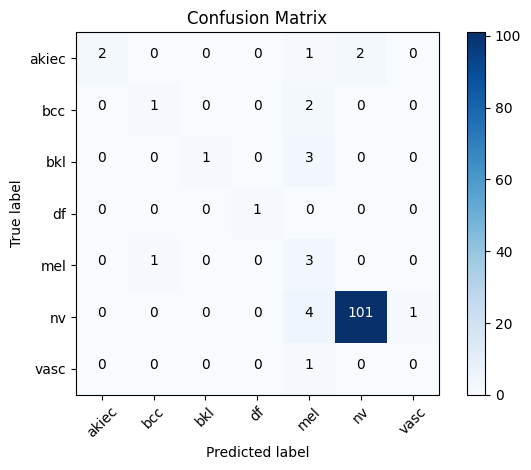

In [74]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [75]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [76]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       1.00      0.40      0.57         5
         bcc       0.50      0.33      0.40         3
         bkl       1.00      0.25      0.40         4
          df       1.00      1.00      1.00         1
         mel       0.21      0.75      0.33         4
          nv       0.98      0.95      0.97       106
        vasc       0.00      0.00      0.00         1

    accuracy                           0.88       124
   macro avg       0.67      0.53      0.52       124
weighted avg       0.94      0.88      0.89       124



In [77]:
model_json = model.to_json()
with open("model.json", "w") as j_file:
    j_file.write(model_json)

In [78]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk


**Resources**

https://www.kaggle.com/vbookshelf/skin-lesion-analyzer-tensorflow-js-web-app